#### Import Modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

#### Load and prep the data

In [2]:
loans = pd.read_csv('loan_default.csv')
loans.head(3)

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1


In [3]:
ids = pd.DataFrame(loans.LoanID)
df = loans.drop('LoanID', axis=1)
ids.head(2)

,LoanID
0,I38PQUQS96
1,HPSK72WA7R


In [4]:
categorical_features = ['Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 
                        'HasDependents', 'LoanPurpose', 'HasCoSigner']
dflog = pd.get_dummies(df, columns = categorical_features, dtype=int)

#### Split and scale data

In [5]:
X = dflog.drop('Default', axis=1)
y = dflog['Default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# KNN Model Performance by number of neighbors

In [7]:
neighbors = np.arange(1, 13)
train_accuracies = {}
test_accuracies = {}
for neighbor in neighbors:
	knn = KNeighborsClassifier(n_neighbors=neighbor)
	knn.fit(X_train, y_train)
	train_accuracies[neighbor] = knn.score(X_train, y_train)
	test_accuracies[neighbor] = knn.score(X_test, y_test)

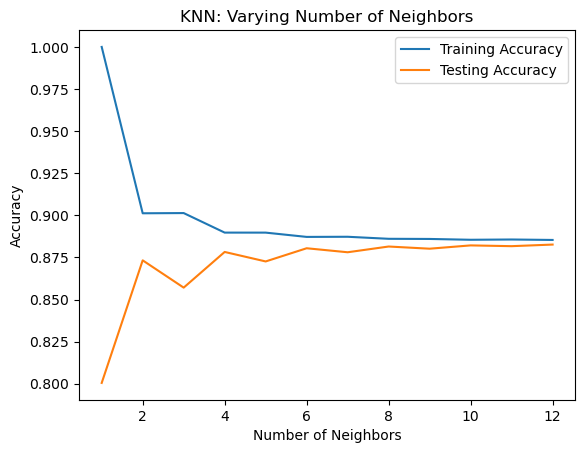

In [8]:
plt.title("KNN: Varying Number of Neighbors")
plt.plot(neighbors, train_accuracies.values(), label="Training Accuracy")
plt.plot(neighbors, test_accuracies.values(), label="Testing Accuracy")
plt.legend()
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
plt.show()

In [9]:
logreg = LogisticRegression()
tree = DecisionTreeClassifier()
knn = KNeighborsClassifier(n_neighbors=6)
kf = KFold(n_splits=6, random_state=42, shuffle=True)

models = {'Logistic Regression': logreg, 'KNN': knn, 'Decision Tree': tree}
metrics = {'accuracy': accuracy_score, 'f1': f1_score, 'precision': precision_score, 'recall': recall_score, 'ROC AUC': roc_auc_score}

# Classification Model Performaces across multiple metrics

## Performance by Model

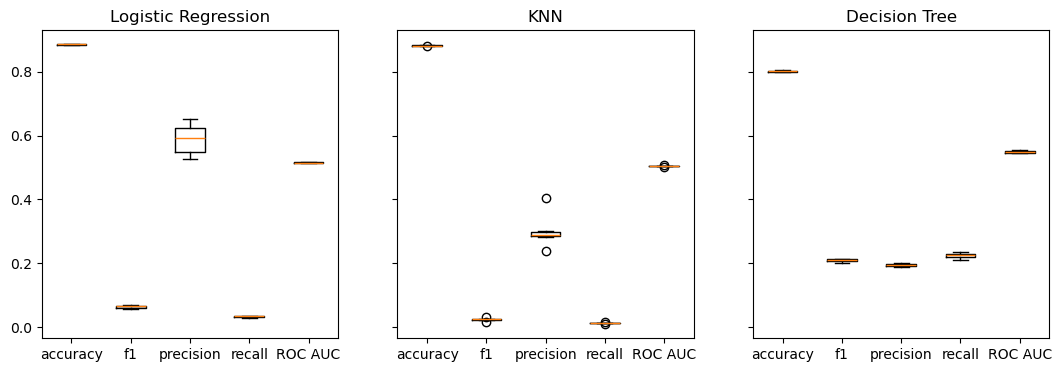

<Figure size 640x480 with 0 Axes>

In [10]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(13, 4), sharey=True)
i_ax = iter(axs)
for name, model in models.items():
    results = []
    ax = next(i_ax)
    for metric in metrics.values():
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=kf, scoring=make_scorer(metric))
        results.append(cv_scores)
    ax.boxplot(results, tick_labels=metrics.keys())
    ax.set_title(name)
plt.figure(layout='compressed')
plt.show()

## Performance by Metric

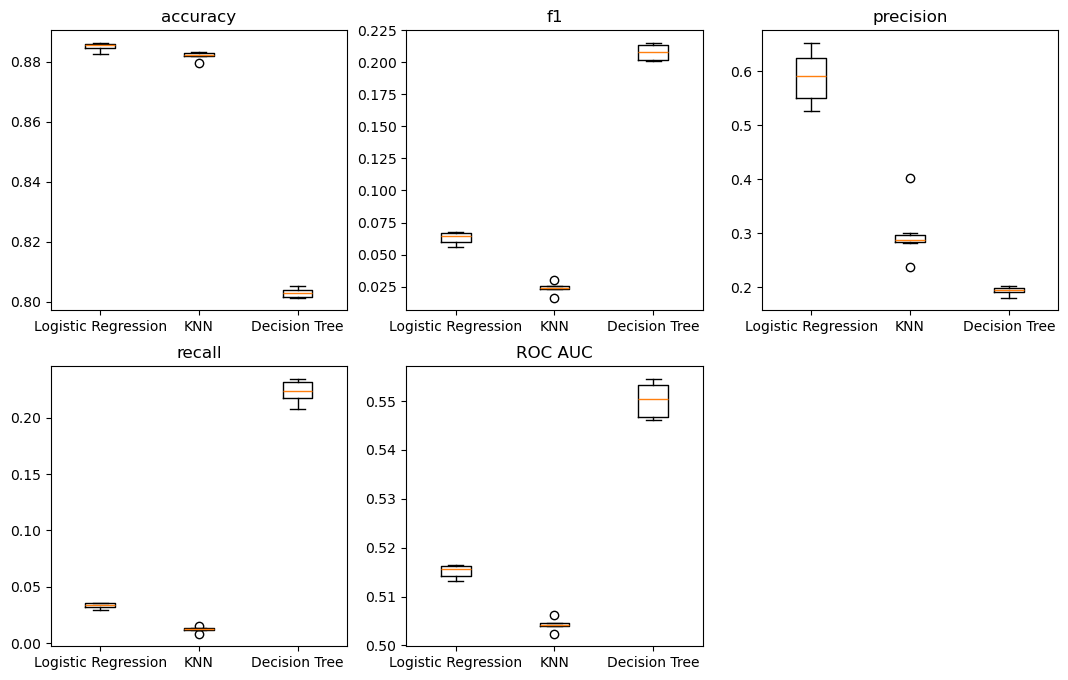

<Figure size 640x480 with 0 Axes>

In [11]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(13, 8))
i_ax = axs.flat
for name, metric in metrics.items():
    results = []
    ax = next(i_ax)
    for model in models.values():
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=kf, scoring=make_scorer(metric))
        results.append(cv_scores)
    ax.boxplot(results, tick_labels=models.keys())
    ax.set_title(name)
fig.delaxes(axs[1, 2])
plt.figure(layout='constrained')
plt.show()

# Model Performance on undersampled data

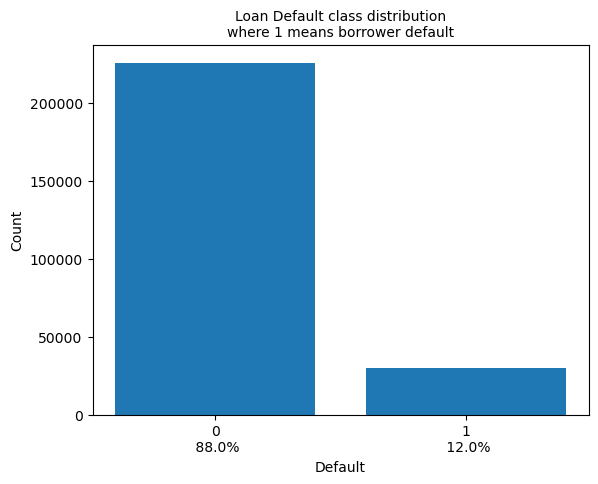

In [12]:
default_counts = loans['Default'].value_counts()
default_percentages = pd.Series([(x / loans.shape[0]) * 100.00 for x in default_counts])

fig, ax = plt.subplots()
ax.bar(default_counts.index, default_counts)
ax.set_xticks([0, 1])
ax.set_xticklabels(default_percentages.index.astype(str) + '\n' + ' ' +
                   default_percentages.round(0).astype(str) + '%')
ax.set_ylabel('Count')
ax.set_xlabel('Default')
ax.set_title('Loan Default class distribution\nwhere 1 means borrower default', fontsize = 10)
plt.show()

While the data is not severly skewed, training and testing the models on balanced data might change the performance of our models.

## Undersampling the Split Data for Logistic Regression

In [13]:
type(X_train), type(y_train)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

### How many defaults?

In [14]:
y_train_df = pd.DataFrame(y_train, dtype='int')
total_defaults = y_train_df.value_counts()[1]
y_train_df.value_counts()

Default
0          158013
1           20729
Name: count, dtype: int64

#### Undersampled y training data

In [15]:
y_train_non_defaulters_undersampled = y_train[y_train == 0].sample(n=total_defaults)
y_train_defaulters = y_train[y_train == 1]
y_train_undersampled = pd.concat([y_train_defaulters, y_train_non_defaulters_undersampled])
y_train_undersampled.head(3)

73275     1
38482     1
163501    1
Name: Default, dtype: int64

#### Undersampled X training data

In [16]:
y_train_undersampled_df = pd.DataFrame(y_train_undersampled)
undersampled_df = y_train_undersampled_df.merge(X_train, how='left', left_index=True, right_index=True)
X_train_undersampled = undersampled_df.drop('Default', axis=1)
X_train_undersampled.head(2)

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education_Bachelor's,...,HasMortgage_Yes,HasDependents_No,HasDependents_Yes,LoanPurpose_Auto,LoanPurpose_Business,LoanPurpose_Education,LoanPurpose_Home,LoanPurpose_Other,HasCoSigner_No,HasCoSigner_Yes
73275,57,102745,123266,313,1,3,24.99,24,0.88,1,...,1,0,1,0,1,0,0,0,1,0
38482,22,20454,128754,513,21,2,6.68,36,0.67,1,...,1,1,0,0,0,0,0,1,0,1


#### Scale X training and test data

In [17]:
scaler = StandardScaler()
X_train_undersampled_scaled = scaler.fit_transform(X_train_undersampled)
X_test_scaled = scaler.transform(X_test)

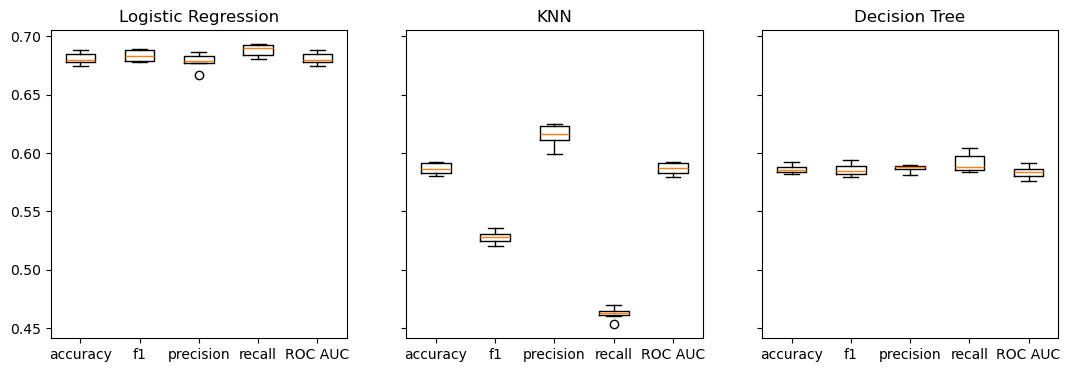

<Figure size 640x480 with 0 Axes>

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(13, 4), sharey=True)
i_ax = iter(axs)
for name, model in models.items():
    results = []
    ax = next(i_ax)
    for metric in metrics.values():
        cv_scores = cross_val_score(model, X_train_undersampled_scaled, y_train_undersampled, cv=kf, scoring=make_scorer(metric))
        results.append(cv_scores)
    ax.boxplot(results, tick_labels=metrics.keys())
    ax.set_title(name)
plt.figure(layout='compressed')
plt.show()

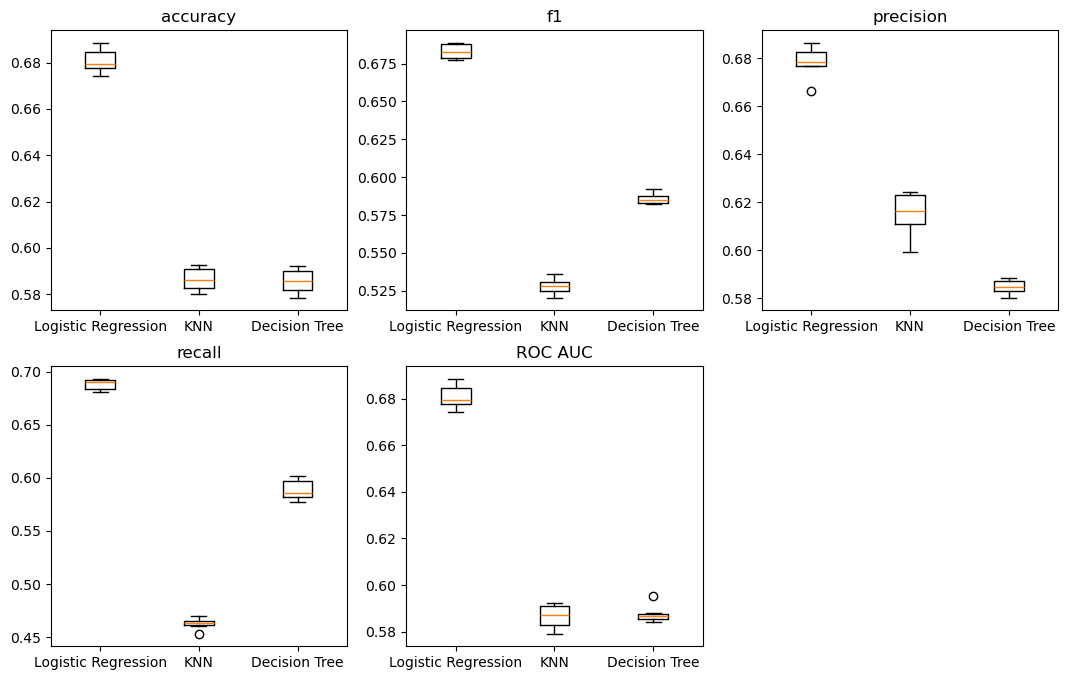

<Figure size 640x480 with 0 Axes>

In [19]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(13, 8))
i_ax = axs.flat
for name, metric in metrics.items():
    results = []
    ax = next(i_ax)
    for model in models.values():
        cv_scores = cross_val_score(model, X_train_undersampled_scaled, y_train_undersampled, cv=kf, scoring=make_scorer(metric))
        results.append(cv_scores)
    ax.boxplot(results, tick_labels=models.keys())
    ax.set_title(name)
fig.delaxes(axs[1, 2])
plt.figure(layout='constrained')
plt.show()

# note: should make this a function

# ROC Curve

In [20]:
logreg.fit(X_train_undersampled_scaled, y_train_undersampled)
y_pred = logreg.predict(X_test_scaled)
y_pred_probs = logreg.predict_proba(X_test_scaled)[:, 1]
confusion_matrix(y_test, y_pred)

array([[45738, 21943],
       [ 2766,  6158]], dtype=int64)

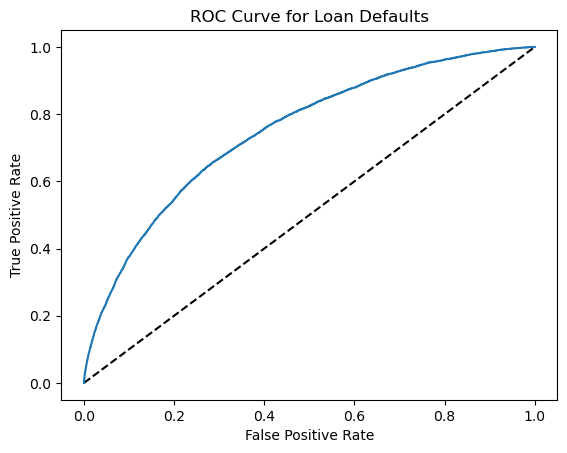

In [21]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Loan Defaults')
plt.show()

# RandomSearchCV Hyperparameter Tuning

In [22]:
params = {"penalty": ["l1", "l2"],
         "tol": np.linspace(0.0001, 1.0, 50),
         "C": np.linspace(0.1, 1.0, 50),
         "class_weight": ["balanced", {0:0.8, 1:0.2}]}

In [23]:
logreg = LogisticRegression(solver='saga')
logreg_cv = RandomizedSearchCV(logreg, params, cv=kf, error_score='raise')
steps = [('scaler', scaler), ('logreg', logreg), ('logreg_cv', logreg_cv)]

In [24]:
logreg_cv.fit(X_train_undersampled_scaled, y_train_undersampled)
y_pred = logreg_cv.predict(X_test_scaled)
confusion_matrix(y_test, y_pred)

array([[46289, 21392],
       [ 3000,  5924]], dtype=int64)

In [25]:
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_))
print("Tuned Logistic Regression Best Accuracy Score: {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameters: {'tol': 0.7551265306122449, 'penalty': 'l2', 'class_weight': 'balanced', 'C': 0.9081632653061225}
Tuned Logistic Regression Best Accuracy Score: 0.6744894852153176


# Test vs. Training Accuracy

In [26]:
training_accuracy = []
test_accuracy = []
accuracy_difference = []

n_splits = 25

clf = LogisticRegression(penalty='l1', class_weight='balanced', C=0.283, max_iter=100, solver='saga')

for i in range(0, n_splits):
    # Split
    Xlr, Xtestlr, ylr, ytestlr = train_test_split(X, y, test_size=0.3, random_state=i)
    
    # Undersample 'ylr'
    ylr_non_defaulters_undersampled = ylr[ylr == 0].sample(n=total_defaults)
    ylr_defaulters = ylr[ylr == 1]
    ylr_undersampled = pd.concat([ylr_defaulters, ylr_non_defaulters_undersampled])
    
    # Undersample 'Xlr'
    ylr_undersampled_df = pd.DataFrame(ylr_undersampled)
    undersampled_df = ylr_undersampled_df.merge(Xlr, how='left', left_index=True, right_index=True)
    Xlr_undersampled = undersampled_df.drop('Default', axis=1)
    
    # Scale 'X'
    Xlr_undersampled_scaled = scaler.fit_transform(Xlr_undersampled)
    Xtestlr_scaled = scaler.transform(Xtestlr)
    
    # Fit 'clf'
    clf.fit(Xlr_undersampled_scaled, ylr_undersampled)
    
    # Predict 'y'
    y_predict_training = clf.predict(Xlr_undersampled_scaled)
    y_predict_test = clf.predict(Xtestlr_scaled)
    
    # Compute training accuracy
    tr_accuracy = accuracy_score(y_predict_training, ylr_undersampled)
    training_accuracy.append(tr_accuracy)
    
    # Compute test accuracy
    tst_accuracy = accuracy_score(y_predict_test, ytestlr)
    test_accuracy.append(tst_accuracy)
    
    # Compute accuracy difference
    accuracy_difference.append(tst_accuracy - tr_accuracy)

In [27]:
print(np.mean(training_accuracy), np.mean(test_accuracy), np.mean(accuracy_difference))

0.68253355928122 0.6760253247177077 -0.006508234563512243


Before hypertuning the scores were: 0.6831274185636315 0.6756953201488155 -0.00743209841481606. It seems that there was a slight sacrifice in training accuracy in contrast to test accuracy. It's not significant.

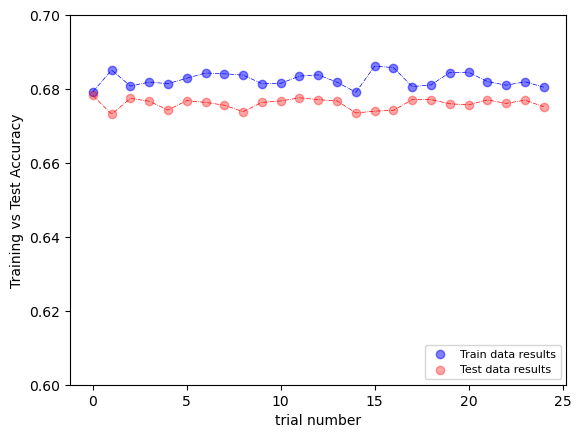

In [28]:
fig, ax = plt.subplots()
ax.scatter(range(len(training_accuracy)),
           training_accuracy, 
           color = 'blue', 
           alpha = 0.5,
           label = 'Train data results')
ax.plot(range(len(training_accuracy)),
        training_accuracy, 
        color = 'blue', 
        linestyle = '-.',
        linewidth = 0.5)
ax.scatter(range(len(test_accuracy)),
           test_accuracy, 
           color = 'red', 
           alpha = 0.35, 
           label = 'Test data results')
ax.plot(range(len(test_accuracy)),
        test_accuracy, 
        color = 'red', 
        linestyle = '-.',
        linewidth = 0.5)
ax.legend(fontsize = 8, loc = "lower right")
ax.set_ylabel('Training vs Test Accuracy')
ax.set_ylim(0, 1)
ax.set_xlabel('trial number')
ax.set_ybound(lower=0.6, upper=0.7)
plt.show()